In [148]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.dataloader import DataLoader, labelEncoding, labelDecoding
from src.constants import constants

get_loader = DataLoader(data_dir=f"{constants.data.FINAL_PATH}/groundtruth.csv",
                        aps_list=constants.aps, batch_size=30, step_size=5,
                        size_reference_point_map=28, return_axis_coords=True)

X, y, [x_coords, y_coords] = get_loader()

rpmap, rpmap_labels = X[:,:,:,0], y[:,0]
rpmap_encoding = labelEncoding(rpmap_labels)

# Transform to tabular data to train radiomap


# Obtener radiomap desde el RPMAP

Objetivo:

Transformar X en datos tabulares estilo radiomap:


(223*28*28=174832 filas, 7 columnas wifi + 2 columnas coordenadas)

In [170]:
# contantes para la operación de transformación a radiomap
samples_per_RP = int(rpmap.shape[0]/len(constants.aps)) # 223 instancias temporales por cada ap
size_map = rpmap.shape[1] # 28x28 puntos de referencia
radiomap = np.zeros((samples_per_RP*size_map*size_map, len(constants.aps)+2)) # 174832 filas, 7 columnas wifi + 2 columnas coordenadas
count = 0 # inicializamos el contador de filas
rpmap_flatten = rpmap.reshape(int(rpmap.shape[0]), size_map*size_map) # aplanamos cada mapa de referencia

for batch in range(samples_per_RP): # para cada instancia temporal
    for idx_coord, (x, y) in enumerate(zip(x_coords, y_coords)): # para cada coordenada
        for n_ap in range(len(constants.aps)): # para cada ap
            radiomap[count, n_ap] = rpmap_flatten[batch+n_ap*samples_per_RP, idx_coord] # guardamos el valor de la señal wifi en la fila correspondiente
        radiomap[count, len(constants.aps)] = x # guardamos la coordenada x
        radiomap[count, len(constants.aps)+1] = y # guardamos la coordenada y
        count += 1 # incrementamos el contador de filas

# creamos un dataframe con los datos de radiomap
radiomap_df = pd.DataFrame(radiomap, columns = constants.aps + ['Longitude', 'Latitude'])

Ahora que hemos convertido nuestro conjunto de datos, de datos de imagenes de mallado continuo de RP al formato de radiomap. Podemos obtener de manera directa la imagen de RSS para cada punto de referencia en cada AP (como la media de todos los RSS en un punto (latitud, longitud) en todos los instantes de tiempo).

In [173]:
grouped_df = radiomap_df.groupby(["Longitude", "Latitude"]).mean().reset_index()

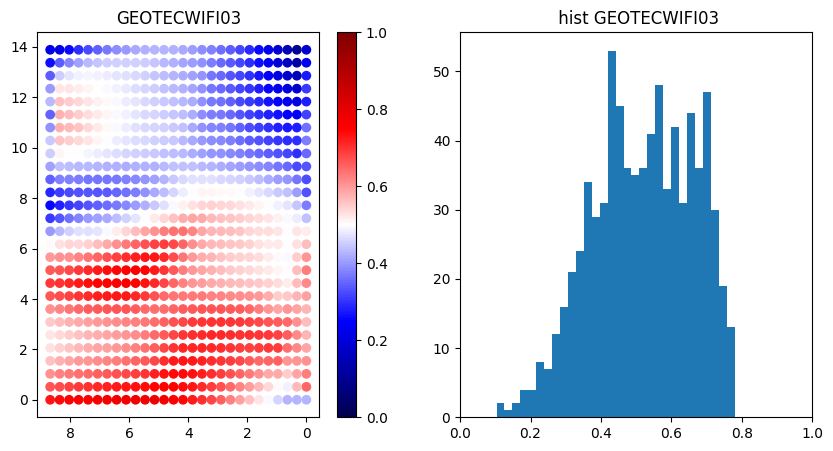

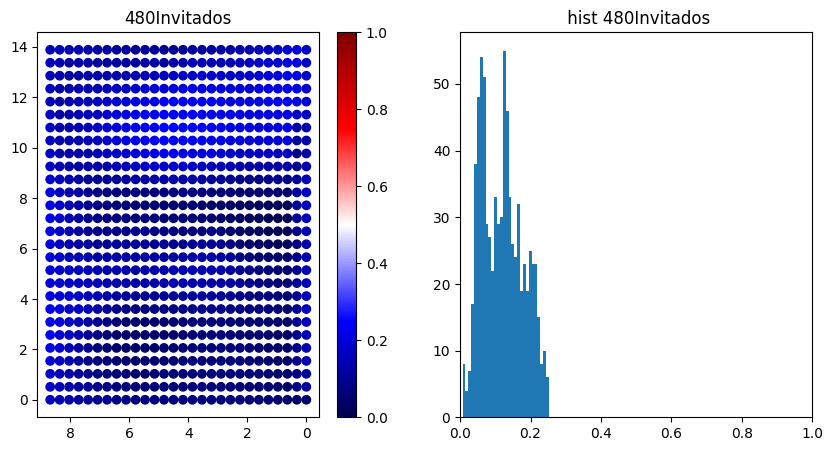

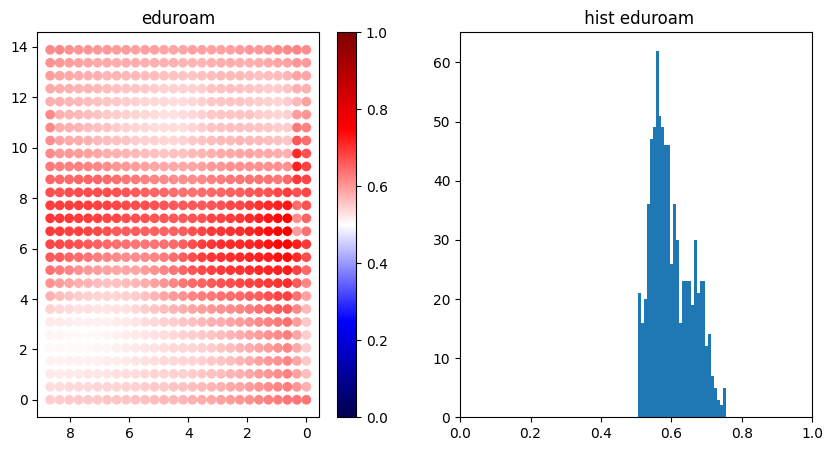

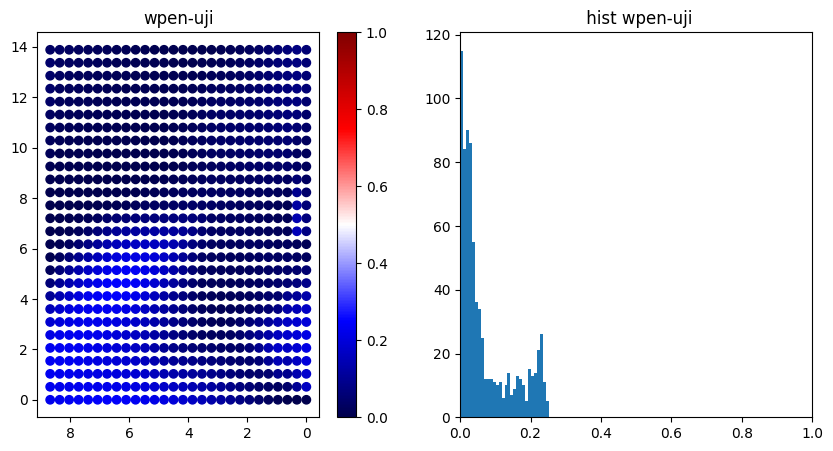

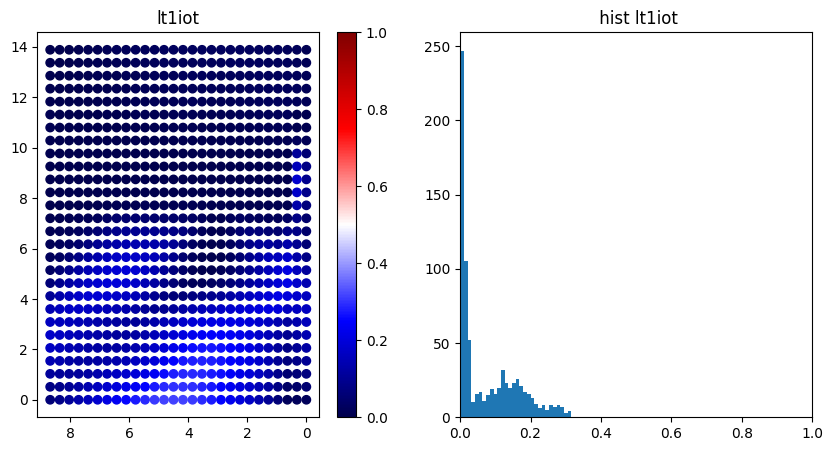

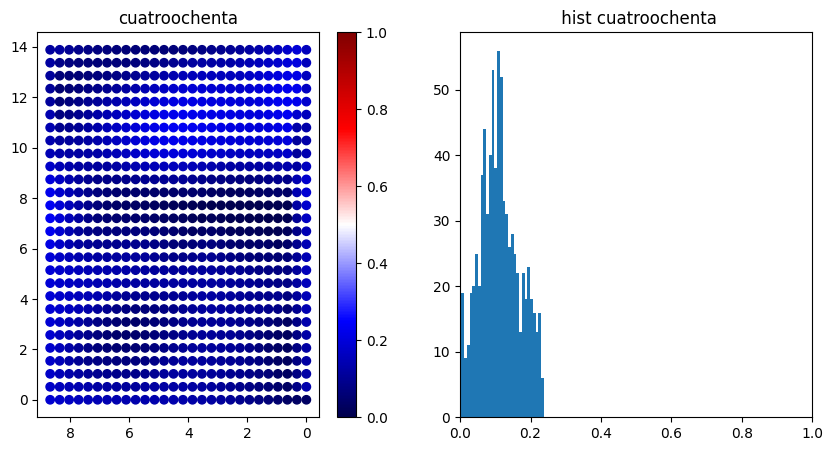

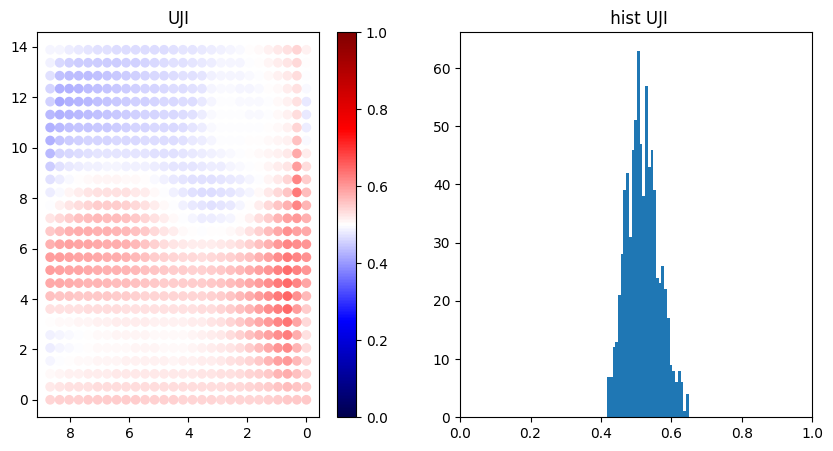

In [177]:
for ap in constants.aps:
    plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.scatter(grouped_df["Longitude"], grouped_df["Latitude"], c=grouped_df[ap], cmap='seismic', vmin=0, vmax=1)
    plt.colorbar(); plt.gca().invert_xaxis()
    plt.title(ap)
    plt.subplot(122)
    plt.hist(grouped_df[ap], bins=30)
    plt.xlim((0,1))
    plt.title(f" hist {ap}")
    plt.show()

# Modelos de estimación de posicionamiento

Una vez hemos realizado la transformación a radiomap, podemos aplicar modelos de estimación de coordenadas y calcular el error correspondiente

In [ ]:

import os
import sklearn as sk

from positioning import utils

# Splitting train and test
X = radiomap_df[constants.aps].to_numpy()
y = radiomap_df[["Longitude", "Latitude"]].to_numpy()
Xtrain, Xtest, ytrain, ytest = sk.model_selection.train_test_split(X, y, test_size=0.3, random_state=42)


# creating paths
print("........ creating paths ........")
with_rpmap = f"{constants.outputs.positioning.positioning_path}/with_rpmap"
line_plot_path = f"{with_rpmap}/line_plot_metrics"
preds_vs_true_path = f"{with_rpmap}/preds_vs_true"
positioning_estimation_path = f"{with_rpmap}/positioning_estimation"
os.makedirs(with_rpmap, exist_ok=True)
os.makedirs(line_plot_path, exist_ok=True)
os.makedirs(preds_vs_true_path, exist_ok=True)
os.makedirs(positioning_estimation_path, exist_ok=True)

print("........ training hyperparameters knn ........")
metricas_knn = utils.results_knn_training(Xtrain=Xtrain, Xtest=Xtest, ytrain=ytrain, ytest=ytest,
                                          k_neighbors=[x for x in range(1, 11)], sort_by_rmse=True)

print(
    f"........ saving train results to {positioning_estimation_path}/metricas_knn.csv........")
metricas_knn.to_csv(f"{positioning_estimation_path}/metricas_knn.csv", index=False)

print("........ training hyperparameters rf ........")
metricas_rf = utils.results_rf_training(Xtrain=Xtrain, Xtest=Xtest, ytrain=ytrain, ytest=ytest,
                                        n_trees=[10, 100, 500, 1000, 2000, 5000], sort_by_rmse=True)
print(
    f"........ saving train results to {positioning_estimation_path}/metricas_rf.csv........"
)
metricas_rf.to_csv(f"{positioning_estimation_path}/metricas_rf.csv", index=False)

print("........ saving line plot metrics knn ........")
utils.knn_line_plot_metrics(results=metricas_knn, y_label="Error (m)", title="KNN",
                            path_out=line_plot_path,
                            save_ok=True)

print("........ saving line plot metrics rf ........")
utils.rf_line_plot_metrics(results=metricas_rf, y_label="Error (m)", title="RF",
                           path_out=line_plot_path,
                           save_ok=True)

print("........ saving plot true vs pred ........")

best_params_knn = int(metricas_knn.iloc[0]["k_neighbors"])
best_params_rf = int(metricas_rf.iloc[0]["n_trees"])
ypred_knn = sk.neighbors.KNeighborsRegressor(n_neighbors=best_params_knn).fit(Xtrain, ytrain).predict(Xtest)
ypred_rf = sk.ensemble.RandomForestRegressor(n_estimators=best_params_rf, random_state=42).fit(Xtrain, ytrain).predict(Xtest)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.scatter(ytest[:, 0], ytest[:, 1], label="ytrue", s=100)
plt.gca().invert_xaxis()
plt.scatter(ypred_knn[:, 0], ypred_knn[:, 1], label="KNN", alpha=0.5)
plt.gca().invert_xaxis(); plt.legend(); plt.title(f"KNN(k={best_params_knn})")
plt.xlabel("Longitude"); plt.ylabel("Latitude")
plt.subplot(1, 2, 2)
plt.scatter(ytest[:, 0], ytest[:, 1], label="ytrue", s=100)
plt.gca().invert_xaxis()
plt.scatter(ypred_rf[:, 0], ypred_rf[:, 1], label="RF", alpha=0.5)
plt.gca().invert_xaxis(); plt.legend(); plt.title(f"RF(n={best_params_rf})")
plt.xlabel("Longitude"); plt.ylabel("Latitude")
plt.savefig(f"{preds_vs_true_path}/preds_vs_true.png")
plt.show()


........ creating paths ........
........ training hyperparameters knn ........


100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


........ saving train results to outputs/positioning/with_rpmap/positioning_estimation/metricas_knn.csv........
........ training hyperparameters rf ........


 33%|███▎      | 2/6 [02:23<05:29, 82.38s/it]